# Analysis for GPT paper

This notebook analyses a dataset of Arxiv papers for our paper analysing Deep Learning
as a GPT and its general-purpose-technology dimensions

**Activities**

1. Load the data:
 * Paper metadata
 * Paper topic mix
2. Descriptive analysis of DL as a GPT
 * Rapid improvement: Has there been a rapid increase in the number of DL papers?
   * This includes papers with some DL activity and papers that 'specialise' in DL activity (the DL topic is the maximum or above 0.5)
 * Rapid diffusion in other areas: Has there been an adoption of DL in a wide number of areas?
 * Innovation in other areas: Have the DL papers been influential where they have been adopted (i.e. do they receive more citations than other papers in their category?
3. Geographical aspects of the situation
 * Has there been geographical disruption?
  * How does the geography of DL compare with the geography of research in other Comp Sci disciplines?
  * Has there been more churn in disciplines with higher levels of DL activity?
4. Drivers of the geography of DL
  * Path dependence: to which extent are geographical changes driven by long-standing specialisation in the topic? (Canada)
  * Policy: China (but no AI policy until recently).
  * Complementary assets: Presence of start-ups (based on CrunchBase data?)
  * Disruption
5. Conclusions



## 0. Preamble

In [106]:
%matplotlib inline

#Some imports
import matplotlib.patches as mpatches

import random

#Imports
#Key imports are loaded from my profile (see standard_imports.py in src folder).

#Paths

#Paths
top = os.path.dirname(os.getcwd())

#External data (to download the GRID database)
ext_data = os.path.join(top,'data/external')

#Interim data (to place seed etc)
int_data = os.path.join(top,'data/interim')

#Proc data (to place seed etc)
proc_data = os.path.join(top,'data/processed')

#Figures
fig_path = os.path.join(top,'reports/figures')

#Models
mod_path = os.path.join(top,'models')


#Get date for saving files
today = datetime.datetime.today()

today_str = "_".join([str(x) for x in [today.day,today.month,today.year]])


In [18]:
# Basic functions

#Flatten list

def flatten_list(a_list):
    '''
    Utility function that takes a list of nested elements and flattens it
    
    '''
    
    return([x for el in a_list for x in el])

def flatten_freqs(a_list):
    '''
    Utility function that flattens a list and returns element frequencies
    
    '''
    
    #This flattens the list and returns value counts
    return(pd.Series(flatten_list(a_list)).value_counts())


## 1. Load data

We have two datasets:

1. One includes all CS papers obtained from ArXiv.
2. One includes all CS papers with a DOI (need to check what's the exact difference in status between both categories). 

For now we will focus on number one. We are thinking of number 2 as more of a robustness checks variable.

In [9]:
# Load the papers

papers = pd.read_json(
    ext_data+'/corex_matched_noOAG.json',orient='records')

papers.shape

(247931, 60)

There are 247,931 papers. This is total number of CS + Stats papers in Arxiv CS papers (see methodology in paper for a description of the process used for this)

## 2. Initial exploration

In [10]:
#Note that there are many duplicated papers. This seems to be linked to the way they have been geocoded
len(set(papers.arxiv_id))

131189

In [11]:
#The only difference between papers I can find is in the latitude and longitude. 
#TODO: Check with Joel what's going on here.

#for column in papers.columns:
#    print(column)
#    print(papers.loc[0,column])
#    print(papers.loc[1,column])
#    
#    print('\n')   

In [12]:
#Check the data
papers.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,full_title,grid_lat,grid_lon,institutes,journal,language,match_score,match_value,matched,title
0,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.318119],[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions
1,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,Sparsity-certifying Graph Decompositions,[42.389002],[-72.526712],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,University of Massachusetts Amherst,True,sparsity certifying graph decompositions
2,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
3,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,Intelligent location of simultaneously active ...,[46.049268],[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...
4,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,Sparsely spread CDMA—a statistical mechanics-b...,[52.486],[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...


We have a big bunch of columns with topics (`TOPIC_...`) and metadata from arxiv

Let's check waht the latter are

In [13]:
#Check the col
for column in papers.columns:
    if 'TOPIC' not in column:
        print(column)

arxiv_categories
arxiv_created
arxiv_id
arxiv_raw_summary
arxiv_raw_title
arxiv_sources
arxiv_summary
arxiv_title
citations
date
doi
full_title
grid_lat
grid_lon
institutes
journal
language
match_score
match_value
matched
title


The data is a timestamp so we parse it, and extract the year

In [39]:
papers['date_parsed'] = [datetime.datetime.fromtimestamp(x/1000) for x in papers['date']]

papers['year'] = papers['date_parsed'].apply(lambda x: x.year)

#### Some initial checks

##### Categories

In [40]:
#How many categories are there by paper?
papers.arxiv_categories.apply(lambda x: len(x)).describe()

count    247931.000000
mean          1.916081
std           0.985798
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          13.000000
Name: arxiv_categories, dtype: float64

In [41]:
flatten_freqs(papers.arxiv_categories).head(n=10)

math.IT    38485
cs.IT      38485
cs.LG      28394
cs.CV      24895
stat.ML    20875
cs.AI      20481
cs.DS      19184
cs.CL      16472
cs.NI      15488
cs.LO      12108
dtype: int64

Strong presence of mathematics papers here - even though we are getting the CS papers

##### Language

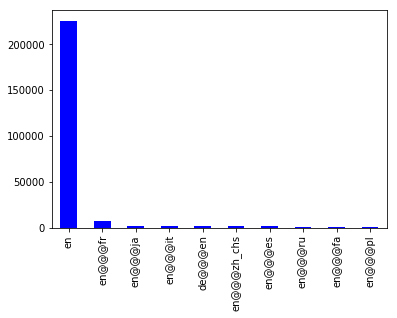

In [42]:
papers.language.value_counts().head(n=10).plot.bar(color='blue')

Not all papers are in English? What does this meaan?

In [43]:
papers.loc[papers['language']=='en@@@ja','full_title'].head()

355    On Profit-Maximizing Pricing for the Highway a...
356    On Profit-Maximizing Pricing for the Highway a...
771    Towards History-based Grammars: Using Richer M...
783    Determination of referential property and numb...
832    DECISION LISTS FOR LEXICAL AMBIGUITY RESOLUTIO...
Name: full_title, dtype: object

They are in English

## 3. Processing

We want to make the data easier to work with.

We will create a df with the topics and an index with the `arxiv_id` and another with other variables we are interested in.

Before doing that we need to deduplicate the papers. The analysis we are doing right now focuses on the diffusion of ML in other topics, for which we don't need individual institution information.

In [44]:
#papers_un means papers unique
papers_un = papers.drop_duplicates('arxiv_id')

papers_un.shape

(131189, 62)

In [45]:
#Create a topic df only including those variables referring to a topic
topics = papers_un.set_index('arxiv_id')[[x for x in papers_un.columns if 'TOPIC' in x]]

topics.head()

,TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence,TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach,TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core,TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known,TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit,TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data,TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way,TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample,TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem,TOPIC_experiment_experiment show_extensive experiment_high quality_high_result indicate_quality_indicate_extensive_resolution,...,TOPIC_prove_class_game_general_player_also_hold_existence_theoretic_exists,TOPIC_real_real world_world_widely_widely used_wide_wide range_application_synthetic_commonly used,TOPIC_research_year_ha_recent_human_community_attention_recent year_challenge_become,TOPIC_service_security_mobile_device_traffic_technology_resource_attack_internet_management,TOPIC_simulation_system_simulation result_control_energy_design_controller_simulation result show_sensor_efficiency,TOPIC_social_social network_role_play_robot_dynamic_interaction_decision making_decision_autonomous,TOPIC_software_development_implementation_tool_program_open source_interface_science_programming_execution,TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural,TOPIC_user_account_insight_impact_analysis_provide_study_focus_issue_take account,TOPIC_web_future_social medium_medium_project_business_twitter_organization_review_content
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,0.428542,0.042882,0.0,0.000000,0.000000,0.000000,0.000000,0.074204,0.052545,0.0,...,0.058000,0.0,0.135712,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
oai:arXiv.org:0704.0047,0.157418,0.042882,0.0,0.000000,0.054565,0.526032,0.524284,0.020608,0.000000,0.0,...,0.028615,0.0,0.000000,0.0,0.016941,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0050,0.206328,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.049272,0.0,0.000000,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0098,0.000000,0.015733,0.0,0.034355,0.163856,0.000000,0.000000,0.050527,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.079938,0.0,0.0,0.0,0.022756,0.0
oai:arXiv.org:0704.0217,0.026281,0.015733,0.0,0.032564,0.472709,0.000000,0.000000,0.021966,0.000000,0.0,...,0.020230,0.0,0.000000,0.0,0.095396,0.0,0.0,0.0,0.000000,0.0


In [46]:
#These are the topics. The neural network topic are 13 and 36. Seems to be picking up more generic machine learning stuff.
for num,x in enumerate(topics.columns):
    print(str(num)+' '+x)

0 TOPIC_algorithm_problem_optimization_optimization problem_solve_solution_solving_approximation_efficient_convergence
1 TOPIC_approach_based_technique_existing_framework_based approach_approach based_new approach_using_novel approach
2 TOPIC_architecture_memory_parallel_network architecture_hardware_processor_cpu_computing_gpu_core
3 TOPIC_bound_upper_upper bound_np_polynomial time_constant_np hard_case_time algorithm_known
4 TOPIC_channel_interference_transmission_wireless_receiver_rate_antenna_transmitter_mimo_transmit
5 TOPIC_data_data set_data structure_real data_data analysis_big data_data driven_data point_collected_synthetic data
6 TOPIC_different_two different_different type_three different_different approach_across different_many different_different level_using different_different way
7 TOPIC_dimensional_sparse_high dimensional_space_sparsity_low rank_vector_dimension_recovery_sample
8 TOPIC_et_al_et al_polynomial_give_whether_proof_complete_every_theorem
9 TOPIC_experiment_e

The DL topics are 13 and 36



In [50]:
topics.columns[[13,36]]

Index(['TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm', 'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural'], dtype='object')

**Question to consider**

* Does it make a lot of sense to consider the coefficient for a topic in Corex as a 'weight'? 
* How useful is it to distinguish between 'specialist' and 'embedded' DL papers given that many other topics don't appear to be particularly tight?

In [59]:
#And now we create a paper metadata df.
# Note that we have to set the index after subsetting (otherwise the subsetting can't find the arxiv id in the columns!)
papers_meta = papers_un[[x for x in papers_un.columns if 'TOPIC' not in x]].set_index('arxiv_id')

papers_meta.head()

,arxiv_categories,arxiv_created,arxiv_raw_summary,arxiv_raw_title,arxiv_sources,arxiv_summary,arxiv_title,citations,date,doi,...,grid_lon,institutes,journal,language,match_score,match_value,matched,title,date_parsed,year
arxiv_id,,,,,,,,,,,,,,,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]",1175212800000,"We describe a new algorithm, the $(k,\ell)$-pe...",Sparsity-certifying Graph Decompositions,[https://arxiv.org/abs/0704.0002],"[describe, new, algorithm, k, ell, pebble, gam...","[sparsity, certifying, graph, decomposition]",17,1241136000000,10.1007/s00373-008-0834-4,...,[-72.638139],"[smith college, university of massachusetts am...",Graphs and Combinatorics,en,1.0,Smith College,True,sparsity certifying graph decompositions,2009-05-01 01:00:00,2009
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",1175385600000,The intelligent acoustic emission locator is d...,Intelligent location of simultaneously active ...,[https://arxiv.org/abs/0704.0047],"[intelligent, acoustic, emission, locator, des...","[intelligent, location, simultaneously, active...",8,1044057600000,10.1108/00022660310457248,...,[14.505099],[university of ljubljana],Aircraft Engineering and Aerospace Technology,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2003-02-01 00:00:00,2003
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",1175385600000,Part I describes an intelligent acoustic emiss...,Intelligent location of simultaneously active ...,[],"[part, describes, intelligent, acoustic, emiss...","[intelligent, location, simultaneously, active...",0,1167609600000,None,...,[14.505099],[university of ljubljana],arXiv preprint arXiv:0704.0050,en,1.0,University of Ljubljana,True,intelligent location of simultaneously active ...,2007-01-01 00:00:00,2007
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]",1175385600000,"Sparse Code Division Multiple Access (CDMA), a...",Sparsely-spread CDMA - a statistical mechanics...,[https://arxiv.org/abs/0704.0098],"[sparse, code, division, multiple, access, cdm...","[sparsely, spread, cdma, statistical, mechanic...",24,1192147200000,10.1088/1751-8113/40/41/004,...,[-1.8895],"[aston university, hong kong university of sci...",Journal of Physics A,en,1.0,Aston University,True,sparsely spread cdma a statistical mechanics b...,2007-10-12 01:00:00,2007
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",1175472000000,Given a multiple-input multiple-output (MIMO) ...,Capacity of a Multiple-Antenna Fading Channel ...,[https://arxiv.org/abs/0704.0217?context=cs],"[given, multiple, input, multiple, output, mim...","[capacity, multiple, antenna, fading, channel,...",154,1235865600000,10.1109/TIT.2008.2011437,...,"[-87.673945, None]",[northwestern university],IEEE Transactions on Information Theory,en,1.0,Northwestern University,True,capacity of a multiple antenna fading channel ...,2009-03-01 00:00:00,2009


In [60]:
#Select columns of interest
my_columns = ['arxiv_categories','arxiv_raw_summary','arxiv_title', 'citations','year','full_title','journal']

#These columns are picking up the description of the papers, the institutes involved, the journal and the year.
#I need all these things for the analysis of 'diffusion' which is coming up.

papers_meta = papers_meta[my_columns]

papers_meta.head()

,arxiv_categories,arxiv_raw_summary,arxiv_title,citations,year,full_title,journal
arxiv_id,,,,,,,
oai:arXiv.org:0704.0002,"[math.CO, cs.CG]","We describe a new algorithm, the $(k,\ell)$-pe...","[sparsity, certifying, graph, decomposition]",17,2009,Sparsity-certifying Graph Decompositions,Graphs and Combinatorics
oai:arXiv.org:0704.0047,"[cs.NE, cs.AI]",The intelligent acoustic emission locator is d...,"[intelligent, location, simultaneously, active...",8,2003,Intelligent location of simultaneously active ...,Aircraft Engineering and Aerospace Technology
oai:arXiv.org:0704.0050,"[cs.NE, cs.AI]",Part I describes an intelligent acoustic emiss...,"[intelligent, location, simultaneously, active...",0,2007,Intelligent location of simultaneously active ...,arXiv preprint arXiv:0704.0050
oai:arXiv.org:0704.0098,"[cs.IT, math.IT]","Sparse Code Division Multiple Access (CDMA), a...","[sparsely, spread, cdma, statistical, mechanic...",24,2007,Sparsely spread CDMA—a statistical mechanics-b...,Journal of Physics A
oai:arXiv.org:0704.0217,"[cs.IT, math.IT]",Given a multiple-input multiple-output (MIMO) ...,"[capacity, multiple, antenna, fading, channel,...",154,2009,Capacity of a Multiple-Antenna Fading Channel ...,IEEE Transactions on Information Theory


## 2. Analysis

### a. Paper classification
Our first stage is a descriptive analysis of DL activity: in order to do this, we need to combine the paper data and the topic mix data and then label papers based on the relative importance of the DL topics. We will then plot some descriptives.

We will start with a class that classifies papers depending on the presence of DL topics. Since we have two topics and it is not straightforward to combine coefficients into a single 'DL weight', we will classify the papers twice and then combine all the information to generate a DL variable.

In [138]:
class DlPaperClassification():
    '''
    The class takes a paper df, a topic mix and an index for the topics which contain DL.

    It has a .label_papers method that takes the topic mix and categories papers into DL groups.
    
    It also generates a categorical variable indicating if a paper is 'specialist' (dl is top category) or 
    embedded (dl is simply present)
        
    '''
    
    def __init__(self,papers,topic_mix,dl_var):
        '''
        Initialise the class with a papers file,
        A topic mix file and a list of DL categories.
        
        '''
        
        #NB we will have 
        self.papers = papers
        self.topics = topic_mix
        
        #This can be more than one
        self.dl_var = dl_var
        
        
    def label_papers(self,thres=0.2):
        '''
        We label papers into different levels of DL activity based on the weight
        in their topic mix
        -present if it is above a certain threshold
        -top if it is the top topic (not necessarily above 0.5)
        
        '''
        
        #Load all the information we need for the analysis
        papers = self.papers
        topics = self.topics
        dl_var = self.dl_var
        
        #Classify papers into categories
        #Is the DL topic present?
        dl_present = pd.Series(topics[dl_var].apply(lambda x: x>thres),
                              name='dl_present')
        
        #Is the DL topic the biggest one?
        dl_max = pd.Series(topics.idxmax(axis=1)==dl_var,name='dl_spec')
                
        #Concatenate all categories and index them (to concatenate with the papers in a moment)
        dl_all_class = pd.concat([dl_present,dl_max],axis=1)
        
        #We define an 'embed' category if papers have dl presence but are not specialised
        dl_all_class['dl_embed'] = (dl_all_class['dl_present']==True) & (dl_all_class['dl_spec']==False)
        
        dl_all_class.index = topics.index
        
        #Concatenate papers and our topic classification
        papers_lab = pd.concat([papers,dl_all_class],axis=1)
        
        #And give them a categorical variable depending on whether they are specialist or embedded
        papers_lab['dl_category'] = ['dl_spec' if x==True else 'dl_embed' if y==True else 'not_dl' for
                                      x,y in zip(papers_lab['dl_spec'],papers_lab['dl_embed'])]
    
        #Save outputs
        #Labels stores the labels we have created
        self.labels = dl_all_class
        
        #Papers_lab stores the paper metadata labelled
        self.papers_lab = papers_lab
        
        #topics_agg stores the aggregated topics (mostly for checking)
        #self.topics_agg = topic_aggregated     
        
        return(self)

In [139]:
#Run the analysis for both classes
dl_vars = [
    'TOPIC_learning_neural_neural network_training_machine learning_classification_trained_machine_learn_learning algorithm',
    'TOPIC_state art_art_state_deep_convolutional_convolutional neural_convolutional neural network_deep learning_datasets_deep neural']

#Each of the elements in dl classified is the output of the classification for a topic
dl_classified = [DlPaperClassification(papers_meta,topics,var).label_papers().labels for var in dl_vars]

In [140]:
#These are the totals for both categories
pd.concat([dl_classified[0].sum(),dl_classified[1].sum()],axis=1)

,0,1
dl_present,24127,14576
dl_spec,3803,8890
dl_embed,20387,6090


In [141]:
#We create two lists of dl papers: one that appears in either topic (expansive) and one that appears in both (restrictive)

#Expansive (is in both)
papers_expansive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) | (dl_classified[1]['dl_present']==True)].index

#Restrictive (is only in one)
papers_restrictive = dl_classified[0].loc[(dl_classified[0]['dl_present']==True) & (dl_classified[1]['dl_present']==True)].index

print(len(papers_expansive))
print(len(papers_restrictive))

30652
8051


In [142]:
# Now we want to explore those papers

def sense_checker(data,text_var,sample_size=10,text_size=300):
    '''
    This function takes a dataset, draws random samples from it and prints the text so we can sense-check the quality of the matches.
    
    '''
    
    #Draw a random sample of size sample size from the data
    drawn = random.sample(list(data.index),sample_size)
    
    #return(data.loc[drawn])
    
    
    #For each element we have drawn from the sample we print the text variable up to the parameter length
    for obs in data.loc[drawn][text_var]:
        print(obs[:text_size])
        print('\n')
    



In [143]:
print('Expansive')
print('=========')
sense_checker(papers_meta.loc[papers_expansive],text_var='arxiv_raw_summary')


print('Restrictive')
print('=========')
sense_checker(papers_meta.loc[papers_restrictive],text_var='arxiv_raw_summary')


Expansive
Variational auto-encoder (VAE) is a powerful unsupervised learning framework
for image generation. One drawback of VAE is that it generates blurry images
due to its Gaussianity assumption and thus L2 loss. To allow the generation of
high quality images by VAE, we increase the capacity of decoder net


Machine Learning has been a big success story during the AI resurgence. One
particular stand out success relates to unsupervised learning from a massive
amount of data, albeit much of it relates to one modality/type of data at a
time. In spite of early assertions of the unreasonable effectiveness of


A large number of protein sequences are becoming available through the
application of novel high-throughput sequencing technologies. Experimental
functional characterization of these proteins is time-consuming and expensive,
and is often only done rigorously for few selected model organisms.
Computa


Machine learning models in practical settings are typically confronted with
chang

The results for both analyses look fine. We will stick with the expansive definition for now (more data)

### b. Descriptive analysis: GPTs

Having selected a set of papers to work with, we address our descriptive research questions.

We will build a class that addresses these questions through its methods:

In [206]:
papers_meta.citations.quantile(0.9)

25.0

In [207]:
#Functions used in the class

def get_cited_papers(data,citation_var,q=0.75):
    '''
    This function subsets a dataset returning the most cited papers of the period (based on the citation variable and the quantile)
    
    '''
    #Get the quantile
    citation_quantile = papers[citation_var].quantile(q)
    
    #Subset the data
    subset_data = data.loc[data[citation_var]>=citation_quantile]

    return(subset_data)


In [585]:
class DlPaperAnalysis_GPT():
    '''
    This class generates descriptive analyses informing our first research question: Is DL a GPT.
    
    It does so with three methods:
    
        .is_growing produces a timeseries comparing levels of activity in DL papers versus the total
        .is_spreading estimates the diffusion of DL papers in different fields
        .is_impactful estimates the citation rates for papers in different fields
    
    '''
    
    def __init__(self,papers,dl_ids):
        ''''
        This function is initialised with the full set of papers and the ids of DL papers
        
        '''
        
        #We label the data with the ids
        papers['is_dl'] = ['dl' if x in dl_ids else 'not_dl' for x in papers.index]
        
        #Store the information
        self.papers = papers
        
        #Also store the DL ids although I doubt we will do much with them
        self.dl_ids = dl_ids
        
        #Extract categories (we are only interested in computer science or statistics / ML)
        categories = [x for x in set(flatten_list(papers.arxiv_categories)) if (x[:2]=='cs') | (x=='stat.ML')]
        self.categories=categories
        
    def is_growing(self,ax,year_lims=(2000,2018),thres_year=2012,high_cited=False):
        '''
        This method charts levels of activity in DL and compares the importance of DL before / after a threshold year
        
        We also give it: 
            -year_lims to subset the x axis
            -thres_year to compare the importance of DL before/after the threshold year
            -high_cited subsets the data to focus on the most highly cited papers each year (its value represents the
            position in the distribution)
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we are focusing on highly cited papers
        if high_cited!=False:
            
            #This loops over years and extracts the top cited papers
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
            
        
        #######################
        #1. Create a timeseries
        #######################
        
        #Create timeseries (note we are subsetting this table with the year lims)
        papers_year = pd.crosstab(papers['year'],papers['is_dl']).loc[year_lims[0]:year_lims[1]]
        
        #Plot
        papers_year.plot.bar(stacked=True,ax=ax)
    
        #Add titles etc
        
        if high_cited==False:
            title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1}'.format(y0=str(year_lims[0]),y1=str(year_lims[1]))
        else:
            title = 'Number of papers in ArXiv (DL / non DL), \n {y0}-{y1} (top {q} citations in year)'.format(y0=str(year_lims[0]),y1=str(year_lims[1]),
                                                                                                              q=str(100*high_cited)+'%')
        
        ax.set_title(title,size=14)
        
        #Store information
        self.papers_year = papers_year
        
        #############################
        #2. Before / after comparison
        ###############################
        
        #Crosstabs a boolean indicating if the year is before / after the threshold and normalise over the rows
        ct = pd.crosstab(papers['year']>thres_year,papers['is_dl'],normalize=0)
        
        #We want to relabel the index of the crosstab to make the output more readable
        y = str(thres_year)
        
        ct.index=['Before '+y, 'After '+y]
        
        self.dl_shares_change= ct
        
    def is_spreading(self,ax,year_lims=(2000,2017),thres_year=2012,high_cited=False,pop_categories=False):
        '''
        
        This method charts the diffusion of DL across domains. 
        One annoying aspect of this is that the papers have multiple categories with no weights. 
        We will expand the data and consider categories separately.
        
        pop_categories allows us to focus on the more popular categories of activity where we expect our share estimates to be more robust.
        
        
        #What are the key outputs:
        
        #Line chart representing DL papers as a share of total in papers with different categories
        #Line chart comparing DL papers as a share of total in different categories before / after threshold.
        
        #Note that the ax argument has two elements for the two figures we are drawing.
        
        '''
        
        #Load papers
        papers = self.papers
        
        #Subset if we have decided to focus on highly cited papers
        if high_cited!=False:
            #This loops over years and extracts the top cited papers (should probably turn this into a function)
            papers = pd.concat([get_cited_papers(papers.loc[papers.year==x,:],'citations',high_cited) for x in np.arange(year_lims[0],year_lims[1])])
            
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.arxiv_categories)[self.categories][:pop_categories].index
            
            
        #######
        #1. Create linechart of activity by category
        ########
        
        #We create a couple of containers to store the data
        #Share container stores the share of DL in total (we will use this for plotting)
        cat_share_container =[]
        
        #Cat total container stores the totals for each category. We use a dict for this
        cat_total_container = {}
        
        
        #We loop over each category of interest
        for cat in categories:
            #Subset the data to identify papers with the category
            subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]
            
            #We crosstab year vs dl categorical
            subset_year = pd.crosstab(subset['year'],subset['is_dl'])
            
            #Store the totals
            cat_total_container[cat] = subset_year
            
            #If there are any DL papers at all
            if 'dl' in subset_year.columns:
                #Calculate the share of DL papers
                subset_year['share'] = subset_year['dl']/subset_year.sum(axis=1)
                
                #We only output the share as a series named after the category (this will become the column name when we concatenate latewr)
                out = pd.Series(subset_year['share'],name=cat)
                
                #Out it comes
                cat_share_container.append(out)
            
        #Create the df filling nas and focusing on our threshold years
        category_share_df = pd.concat(cat_share_container,axis=1).fillna(0).loc[year_lims[0]:year_lims[1]]
        
        
        #Now we plot this.
        #Note that we are assuming that there are too many variables for a legend. We will probably create a cleaner version with nicer labels later.
        category_share_df.rolling(window=3).mean().plot(legend=False,color='mediumblue',alpha=0.7,ax=ax[0])
        
        ax[0].set_title('DL paper shares by ArXiv categories',size=14)
        ax[0].set_ylabel('Share of all papers in category /year')
        
        #Store results
        self.cat_totals = cat_total_container
        self.cat_shares = cat_share_container
        self.cat_shares_df = category_share_df
        
        #########
        #2. Create barchart comparing two intervals
        #########

        cat_period_container = []

        #As before, we loop over categories.
        for cat in categories:
                #Subset the data to identify papers with the category
                subset = papers.loc[[cat in x for x in papers['arxiv_categories']],:]

                #We crosstab a boolean (before / after threshold) vs the dl boolean
                subset_ct = pd.crosstab(subset['year']>thres_year,subset['is_dl'],normalize=0)
                
                #This is to relabel the index (useful for the chart later)
                y = str(thres_year)
                subset_ct.index=['Before '+y, 'After '+y]
        

                #We append to the container, turning into a series so we can rename
                cat_period_container.append(pd.Series(subset_ct['dl'],name=cat))

        #Create the df
        cat_thres_df = pd.concat(cat_period_container,axis=1).T.sort_values('After '+y,ascending=False)
        
        cat_thres_df.plot.bar(ax=ax[1])
        
        ax[1].set_title('Change in DL shares before/after '+str(thres_year),size=14)
        ax[1].set_ylabel('Share of all papers in category/year')
        
        
        #Store the df
        
        self.cat_thres_df = cat_thres_df
            
        
    def is_impactful(self,ax,q=0.75,year_thres=2012,pop_categories=False):
        '''
        Finally, we want to check if DL papers are 'impactful' - do they tend to receive more citations than other papers in each field?
        
        To measure this we will estimate, for each category, what is the share of DL papers in total vs share of highly cited Dl papers. 
        
        We focus on papers published from a threshold year to avoid being skewed by changes in the historical distribution of papers.
        
        '''
        
        #Load papers and categories
        papers = self.papers
        categories = self.categories
        
        cit_cont=[]
        
        #If we are filtering to focus on popular categories
        if pop_categories!=False:
            #This extracts the top categories based on their frequency of appearance in the data
            categories = flatten_freqs(papers.loc[papers.year>year_thres,'arxiv_categories'])[categories][:pop_categories].index
        
        #For each category
        for cat in categories:
            #Here we have the papers since threshold (eg 2012) in the category
            subset = papers.loc[(papers.year>year_thres) & ([cat in x for x in papers['arxiv_categories']])]
            
            #Share of dl in all papers
            dl_all = subset['is_dl'].value_counts(normalize=True)['dl']
            
            #Share of dl in highly cited papers
            #We use a previous function to subset this
            subset_high_cited = get_cited_papers(subset,'citations',q)
            
            dl_high_cited = subset_high_cited['is_dl'].value_counts(normalize=True)['dl']
            
            #out = pd.Series([dl_all,dl_high_cited],index=['dl_share_all','dl_share_high_cited'],name=cat)
            
            #We output an index which normalises the share of high cited papers by the total. 
            #It is positive if DL papers are overrepresented amont the highly cited ones
            out = pd.Series((dl_high_cited/dl_all)-1,index=['high_cited_total_ratio'],name=cat)
        
        
            cit_cont.append(out)
            
        #Create citation df
        citation_df = pd.concat(cit_cont,axis=1).T
        
        #And plot it
        citation_df.sort_values('high_cited_total_ratio',ascending=False).plot.bar(ax=ax,legend=False)
        
        #Add title
        ax.set_title('DL paper citation \'competitiveness\' \n (papers published after {y}, top {q} citations in period))'.format(
            y=str(year_thres),q=str(100*q)+'%'))
        
        #And x label
        ax.set_ylabel('(DL papers share of highly cited/ \n DL papers share of all)-1')
        
        
        #Store the df
        self.citation_impact_df = citation_df

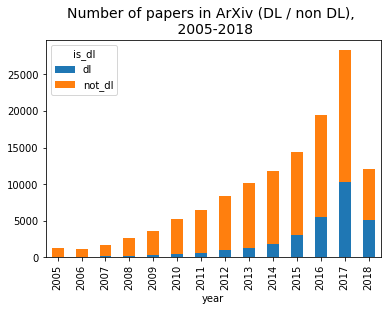

In [586]:
test = DlPaperAnalysis_GPT(papers_meta,papers_expansive)

fig,ax = plt.subplots()

test.is_growing(ax=ax,year_lims=(2005,2018))


Fast increase of activity in ArXiv.

DL appears to be growing at a faster rate, consistent with the 'rapidity' thesis

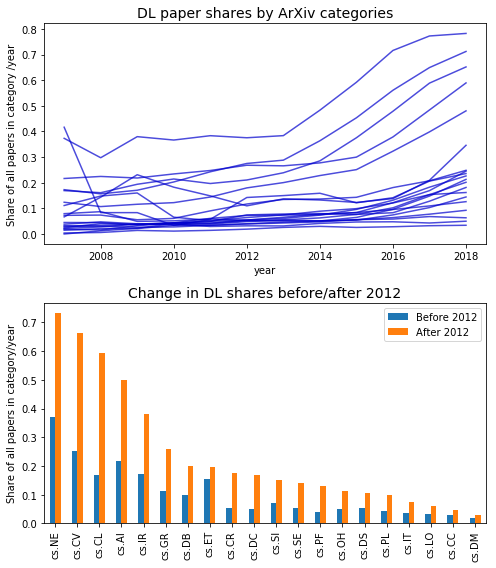

In [583]:
fig,ax = plt.subplots(nrows=2,figsize=(7,8))

test.is_spreading([ax[0],ax[1]],pop_categories=20,year_lims=(2005,2018))

plt.tight_layout()

DL is becoming more important in multiple disciplines. This includes disciplines that specialise in the development of AI technologies (eg `cs.NE` = neural networks, or `cs.AI` = AI) but also others such as Computer Vision, Computation and Language, or Information Retrieval or graphics. 

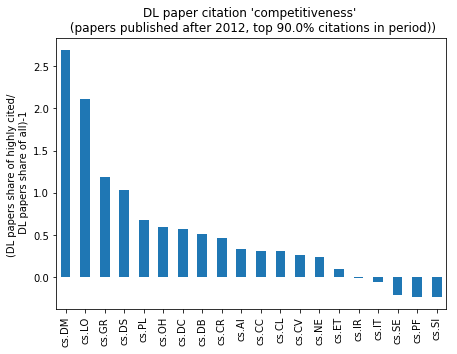

In [587]:
fig,ax = plt.subplots(figsize=(7,5))

test.is_impactful(ax,year_thres=2012,pop_categories=20,q=0.9)

DL papers are overrepresented in the set of influential papers for most CS disciplines with only a few exceptions (software engineering and performance)

Note that some of the most popular topics for DL (in chart above) are quite low in these rankings because DL papers represent the majority of papers in them already


### Conclusion of the descriptive GPT analysis:

DL seems to fulfil all the properties of a GPT: rapid growth, diffusion in multiple areas and impact (which we proxy through citations). Now we need to analyse what this means for its geography.